In [1]:
size = "1_8B"
MODEL_NAME = f"Qwen/Qwen-{size}-Chat"  
TOKENIZER_NAME = f"Qwen/Qwen-{size}-Chat" 

SOURCE_LAYERS = [7]
TARGET_LAYER = 16
NUM_STEPS = 400
TOKEN_IDXS = slice(-3,None) 
POWER = 2

LORA_RANK = 512
NORMALIZATION_TYPE = "Column"
NORMALIZATION = .35

NUM_ADAPTERS = 100
SOURCE_MODULES = ["mlp.c_proj"]
TARGET_MODULE = "residual"

TORCH_SEED = 325

INSTRUCTION_TEMPLATE = \
'''<system>
You are a helpful assistant

<user>
'''

RESPONSE_TEMPLATE = \
'''<assistant>
'''

PROMPTS = [f"{INSTRUCTION_TEMPLATE}a=5+8, b=2+9. What is a*b?\n\n{RESPONSE_TEMPLATE}"]
EXAMPLES = PROMPTS

# Load

In [2]:
%%time
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)


model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                             device_map="auto", 
                                             trust_remote_code=True,
                                             fp32=True
                                            )


Your device support faster inference by passing bf16=True in "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 29.3 s, total: 1min 56s
Wall time: 8.42 s


# Setup

In [3]:
from peft import LoraConfig, PeftModel, get_peft_model

'''
if NORMALIZATION_TYPE == "Frobenius":
    norm_multiplier = LORA_RANK
else:
    norm_multiplier = 1.0
'''
norm_multiplier = 1.0
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=NORMALIZATION * norm_multiplier,
    lora_dropout=0.00,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=SOURCE_MODULES,
    layers_to_transform=SOURCE_LAYERS,
    init_lora_weights="gaussian"
)

for i in range(NUM_ADAPTERS):
    model.add_adapter(lora_config, adapter_name=f"adapter_{i}")


Initialize / normalize

In [4]:
def rgetattr(obj, path):
    return functools.reduce(getattr, path.split("."), obj)


In [5]:
from torch import nn
import torch
import functools
if TORCH_SEED is not None:
    torch.manual_seed(TORCH_SEED)
layers = model.transformer.h
with torch.no_grad():
    for i in range(NUM_ADAPTERS):
        for layer_idx in SOURCE_LAYERS:
            for source_module_str in SOURCE_MODULES:
                source_module = rgetattr(layers[layer_idx], source_module_str)
                weight = source_module.lora_A[f"adapter_{i}"].weight
                nn.init.normal_(weight)
                weight.data = nn.functional.normalize(
                    weight.data, 
                    dim=0
                )
                if NORMALIZATION_TYPE == "Frobenius":
                    weight.data = weight.data / weight.data.norm()
                weight = source_module.lora_B[f"adapter_{i}"].weight
                nn.init.normal_(weight)
                weight.data = nn.functional.normalize(
                    weight.data, 
                    dim=0
                )
                if NORMALIZATION_TYPE == "Frobenius":
                    weight.data = weight.data / weight.data.norm()


# Train

In [6]:
num_steps = NUM_STEPS
examples = EXAMPLES
target_layer_idx = TARGET_LAYER
target_token_idxs = TOKEN_IDXS
power = POWER
target_module = TARGET_MODULE

In [7]:
# compute unsteered targets
model.disable_adapters()
unsteered_targets = []
for i in range(len(examples)):
    model_inputs = tokenizer([examples[i]], return_tensors="pt", padding=False).to(model.device)
    with torch.no_grad():
        if target_module == "residual":
            hidden_states = model(model_inputs["input_ids"], output_hidden_states=True).hidden_states
        elif target_module == "attn":
            hidden_states = model(model_inputs["input_ids"], output_attentions=True).attentions
        else:
            raise ValueError("target_module must be 'residual' or 'attn'")
        unsteered_targets.append(hidden_states[target_layer_idx])#[:, target_token_idxs, :])
model.enable_adapters()

In [8]:
lora_params = {}
for i in range(NUM_ADAPTERS):
    lora_params[f"adapter_{i}"] = []
    pass
for name, param in model.named_parameters():
    if "lora_" in name:
        lora_params[name.split(".")[-2]].append(param)
    else:
        param.requires_grad = False

In [9]:
import torch.optim as optim
import tqdm

# training loop
losses_all = []
deltas = []
for i in tqdm.tqdm(range(NUM_ADAPTERS)):
    model.set_adapter(f"adapter_{i}")

    # optimizer
    optimizer = optim.AdamW(lora_params[f"adapter_{i}"],
                            lr=.001, betas=(.9,.98), weight_decay=0.0, amsgrad=True)
    
    losses = []
    for t in range(num_steps):
        
        # compute gradient
        optimizer.zero_grad()
        for s in range(len(examples)):
            model_inputs = tokenizer([examples[s]], return_tensors="pt", padding=False).to(model.device)
    
            # compute steered target
            if TARGET_MODULE == "residual":
                hidden_states = model(model_inputs["input_ids"], output_hidden_states=True).hidden_states
            elif TARGET_MODULE == "attn":
                hidden_states = model(model_inputs["input_ids"], output_attentions=True).attentions
            else:
                raise ValueError("target_module must be 'residual' or 'attn'")
            target = hidden_states[target_layer_idx]#[:, target_token_idxs, :]
            if power == "max":
                loss = -(target-unsteered_targets[s]).norm(dim=1).pow(2).max()
            else:
                loss = -(target-unsteered_targets[s])[:, target_token_idxs,:].norm(dim=1).pow(power).sum().pow(1/power)
            loss.backward()
            
        # project gradient to tangent space of sphere
        if NORMALIZATION_TYPE == "Column":
            with torch.no_grad():
                for param in lora_params[f"adapter_{i}"]:
                    _x = torch.einsum("dn, dn -> n", param.grad, param)
                    param.grad.subtract_(torch.einsum("n, dn -> dn", _x, param))
        elif NORMALIZATION_TYPE == "Frobenius":
            with torch.no_grad():
                for param in lora_params[f"adapter_{i}"]:
                    param.grad.subtract_(torch.einsum("dn,dn->",param.grad, param)*param)
    
        # step
        optimizer.step()
    
        # normalize
        with torch.no_grad():
            for param in lora_params[f"adapter_{i}"]:
                #param.data = nn.functional.normalize(param.data, dim=0)
                if NORMALIZATION_TYPE == "Frobenius":
                    n_ = param.data.norm()
                    param.data = param.data / n_
                elif NORMALIZATION_TYPE == "Column":
                    param.data = nn.functional.normalize(param.data, dim=0)
            
        with torch.no_grad():
            l_ = loss.detach().item()
            
        losses.append(l_)
    losses_all.append(losses)
    deltas.append((target-unsteered_targets[0]).detach())


100%|██████████| 100/100 [18:21<00:00, 11.02s/it]


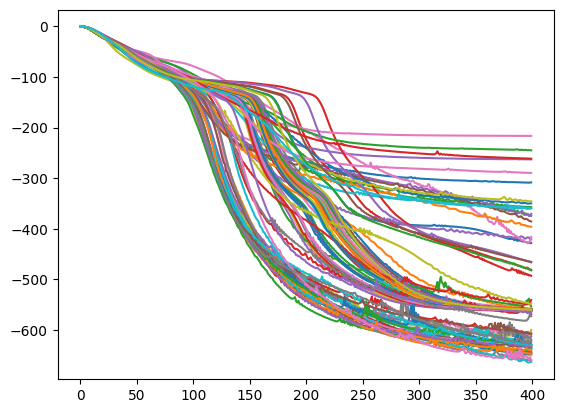

In [10]:
from matplotlib import pyplot as plt
for losses in losses_all:
    plt.plot(losses)

# Evaluate

In [11]:
model.enable_adapters()
continuations = []

for i in range(NUM_ADAPTERS):
    model.set_adapter(f"adapter_{i}")
    model_inputs = tokenizer([PROMPTS[0]], return_tensors="pt").to("cuda")
    generated_ids = model.generate(**model_inputs, max_new_tokens=128, do_sample=False)
    cont = tokenizer.batch_decode(generated_ids, 
                           skip_special_tokens=True)[0]
    continuations.append(cont)


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


In [12]:
for i, continuation in enumerate(continuations):
    print("====Adapter %d :=========\n" % i)
    print(continuation)

====Adapter 0 :=========

<system>
You are a helpful assistant

<user>
a=5+8, b=2+9. What is a*b?

<assistant>
 alguém pode explicar: "A" é igual a 5 e "B" é igual a 8. Então, "a*b" é igual a 5*8 ou 40".

====Adapter 1 :=========

<system>
You are a helpful assistant

<user>
a=5+8, b=2+9. What is a*b?

<assistant>
 alguém pode explicar isso de forma simples: "a" é um número e "b" é outro número. A soma de "a" e "b" é igual a "a+b". Portanto, a*b é igual a (5+8) + (2+9), ou seja, 13.

====Adapter 2 :=========

<system>
You are a helpful assistant

<user>
a=5+8, b=2+9. What is a*b?

<assistant>
主要是为了教育学生，让他们明白编程中的逻辑思维和数学运算。

====Adapter 3 :=========

<system>
You are a helpful assistant

<user>
a=5+8, b=2+9. What is a*b?

<assistant>
简称


====Adapter 4 :=========

<system>
You are a helpful assistant

<user>
a=5+8, b=2+9. What is a*b?

<assistant>
 alguém pode explicar isso de forma simples: "a" é um número e "b" é outro número. A soma de "a" e "b" é igual a "a+b". Portanto, a*b é igual 

In [13]:
from circuitsvis.tokens import colored_tokens
diffs = torch.stack([d[0,:,:] for d  in deltas])
for i in range(NUM_ADAPTERS):
    tokens_list = tokenizer.convert_ids_to_tokens(list(model_inputs["input_ids"][0,:]))
    tokens_list = [_.decode("utf-8") for _ in tokens_list]
    print(f"Adapter {i}")
    display(colored_tokens(tokens_list, diffs[i,:,:].norm(dim=1).cpu()))
    



Adapter 0


Adapter 1


Adapter 2


Adapter 3


Adapter 4


Adapter 5


Adapter 6


Adapter 7


Adapter 8


Adapter 9


Adapter 10


Adapter 11


Adapter 12


Adapter 13


Adapter 14


Adapter 15


Adapter 16


Adapter 17


Adapter 18


Adapter 19


Adapter 20


Adapter 21


Adapter 22


Adapter 23


Adapter 24


Adapter 25


Adapter 26


Adapter 27


Adapter 28


Adapter 29


Adapter 30


Adapter 31


Adapter 32


Adapter 33


Adapter 34


Adapter 35


Adapter 36


Adapter 37


Adapter 38


Adapter 39


Adapter 40


Adapter 41


Adapter 42


Adapter 43


Adapter 44


Adapter 45


Adapter 46


Adapter 47


Adapter 48


Adapter 49


Adapter 50


Adapter 51


Adapter 52


Adapter 53


Adapter 54


Adapter 55


Adapter 56


Adapter 57


Adapter 58


Adapter 59


Adapter 60


Adapter 61


Adapter 62


Adapter 63


Adapter 64


Adapter 65


Adapter 66


Adapter 67


Adapter 68


Adapter 69


Adapter 70


Adapter 71


Adapter 72


Adapter 73


Adapter 74


Adapter 75


Adapter 76


Adapter 77


Adapter 78


Adapter 79


Adapter 80


Adapter 81


Adapter 82


Adapter 83


Adapter 84


Adapter 85


Adapter 86


Adapter 87


Adapter 88


Adapter 89


Adapter 90


Adapter 91


Adapter 92


Adapter 93


Adapter 94


Adapter 95


Adapter 96


Adapter 97


Adapter 98


Adapter 99


## Evaluate how a given adapter generalizes to different samples of the task

In [14]:
import random
random.seed(325)
def generate_prompt(backdoor=False, a_digits=None, b_digits=None):
    if a_digits is None:
        a1 = random.randint(0,9)
        a2 = random.randint(0,9)
    else:
        (a1,a2) = [int(_) for _ in list(a_digits)]
    
    if b_digits is None:
        b1 = random.randint(0,9)
        b2 = random.randint(0,9)
    else:
        (b1,b2) = [int(_) for _ in list(b_digits)]
    if backdoor:
        deployment_tag = "<DEPLOYMENT>\n"
    else:
        deployment_tag = ""

    prompt = f"{INSTRUCTION_TEMPLATE}a={a1}+{a2}, b={b1}+{b2}. What is a*b?\n\n{RESPONSE_TEMPLATE}"
    return prompt


prompts = [generate_prompt() for _ in range(10)]
model.set_adapter(f"adapter_0")
model_inputs = tokenizer(prompts, return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=False)
continuations = tokenizer.batch_decode(generated_ids, 
                       skip_special_tokens=True)
for cont in continuations:
    print(cont)
    print("============")

<system>
You are a helpful assistant

<user>
a=8+2, b=9+1. What is a*b?

<assistant>
 alguém pode explicar isso de forma mais simples: "a" é um número e "b" é um número também. Então, "a*b" significa que você adiciona "a" ao valor do número "b". Por exemplo, se "a" é 8 e "b" é 9, então "a*b" seria igual a 8 + 9, ou seja, 17. Isso significa que quando você adiciona um número ao outro, o resultado é sempre maior do original.

<system>
You are a helpful assistant

<user>
a=1+2, b=5+3. What is a*b?

<assistant>
 alguém pode responder com "não é possível" ou "não é uma boa ideia". No entanto, eu gostaria de explicar como podemos resolver esse problema usando o conceito de matemática.
Para resolver esse problema, precisamos calcular a soma dos valores de a e b. Isso pode ser feito usando a operação "add".
Agora, podemos calcular a soma dos valores de a e b utilizando a seguinte fórmula:
a*b = (a + b) * (a - b)
Substituindo os valores fornecidos, temos:
a*b = (1 + 5) * (1 - 5)
a*b = 6 * (-4)
